# 🌍 Intel Image Classification - Derin Öğrenme Projesi

Bu projede Intel Image Classification veri seti kullanılarak 6 farklı doğal manzara sınıfını sınıflandırmak için bir derin öğrenme modeli geliştirilmiştir.  
Kullanılan sınıflar: `buildings`, `forest`, `glacier`, `mountain`, `sea`, `street`

Kullanılan yöntemler:
- 📦 Data Augmentation (veri artırımı)
- 🧠 Convolutional Neural Network (CNN)
- 📊 Accuracy / Loss Görselleştirmeleri
- 📉 Confusion Matrix

> Bu notebook, eğitim süreci, model performansı ve analizler dahil olmak üzere tüm proje sürecini içermektedir.


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


E0000 00:00:1758885637.446635      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758885637.517617      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 🧾 Veri Yükleme ve Hazırlık

Proje kapsamında kullanılan veri seti, Intel Image Classification veri setidir. Bu veri seti, 6 farklı sınıfa ait 25.000+ eğitim ve 7.000+ test görüntüsünden oluşmaktadır.

Veri seti `/kaggle/input/intel-image-classification/` dizininde yer alır.  
Veri ikiye ayrılmıştır:
- `seg_train/` dizini: Eğitim ve doğrulama verileri
- `seg_test/` dizini: Test verileri

Veri artırımı (Data Augmentation) uygulanarak modelin overfitting’e düşmesi engellenmiş ve genel performansı artırılmıştır. Kullanılan artırma teknikleri:
- Rescale
- Dönme (rotation)
- Kaydırma (shift)
- Zoom
- Parlaklık değiştirme (brightness)
- Yatay çevirme (flip)


## 🧠 Model Mimarisi

Model, görüntü sınıflandırma problemini çözmek üzere sıfırdan oluşturulmuş bir CNN (Convolutional Neural Network) mimarisidir.

Kullanılan katmanlar şunlardır:
- 3 adet **Conv2D + MaxPooling2D** katmanı (özellik çıkarımı için)
- 1 adet **Flatten** katmanı (veriyi düzleştirmek için)
- 1 adet **Dense (128 nöron)** katmanı (öğrenme)
- 1 adet **Dropout (0.5)** katmanı (overfitting’i azaltmak için)
- 1 adet **Dense (6 çıkışlı softmax)** katmanı (6 sınıfa ait olasılık tahmini için)

Model, `categorical_crossentropy` kayıp fonksiyonu ve `adam` (daha sonra learning rate ayarlı) optimizasyon algoritması ile derlenmiştir.


In [2]:
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

# Genişletilmiş Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


## 🏋️ Model Eğitimi

Model, `train_generator` ve `val_generator` kullanılarak 10 epoch boyunca eğitilmiştir.  
Veri seti, `batch_size = 32` olacak şekilde eğitim ve doğrulama setine ayrılmıştır.

Ayrıca modelin overfitting yapmaması için:
- Dropout oranı %50 seçildi
- Learning rate değeri 0.0005 olarak ayarlandı (`Adam(learning_rate=0.0005)`)

Eğitim süreci sonucunda hem eğitim hem de doğrulama başarımı artmış; `accuracy` ve `loss` değerleri her epoch'ta grafiklerle izlenmiştir.


In [3]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))  # 6 sınıf



optimizer = Adam(learning_rate=0.0005)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 351s 996ms/step - accuracy: 0.4744 - loss: 1.3144 - val_accuracy: 0.6724 - val_loss: 0.8982
Epoch 2/10
  1/350 ━━━━━━━━━━━━━━━━━━━━ 4:44 816ms/step - accuracy: 0.8125 - loss: 0.7804

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


350/350 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.8125 - loss: 0.7804 - val_accuracy: 0.6627 - val_loss: 0.9125
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 341s 974ms/step - accuracy: 0.6418 - loss: 0.9480 - val_accuracy: 0.7306 - val_loss: 0.7393
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.8438 - loss: 0.5571 - val_accuracy: 0.7292 - val_loss: 0.7376
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 340s 971ms/step - accuracy: 0.6886 - loss: 0.8375 - val_accuracy: 0.7306 - val_loss: 0.7410
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.6562 - loss: 0.7991 - val_accuracy: 0.7209 - val_loss: 0.7562
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 337s 962ms/step - accuracy: 0.7111 - loss: 0.7738 - val_accuracy: 0.7640 - val_loss: 0.6544
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.7812 - loss: 0.8297 - val_accuracy: 0.7665 - val_loss: 0.6569
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 333s 950ms/step - accuracy: 0.7342 - loss: 0.7243 - va

## 📈 Eğitim Sonuçları: Accuracy & Loss Grafikleri

Aşağıdaki grafiklerde modelin epoch bazında eğitim (`train`) ve doğrulama (`validation`) performansı gösterilmektedir.

- **Accuracy Grafiği:** Modelin sınıfları doğru tahmin etme başarısı
- **Loss Grafiği:** Modelin hata oranı (kayıp değeri)

Grafikler incelendiğinde:
- Eğitim ve doğrulama doğruluğunun artış gösterdiği
- Overfitting'in azaltıldığı
- Modelin dengeli bir şekilde öğrenme gerçekleştirdiği gözlemlenmiştir.


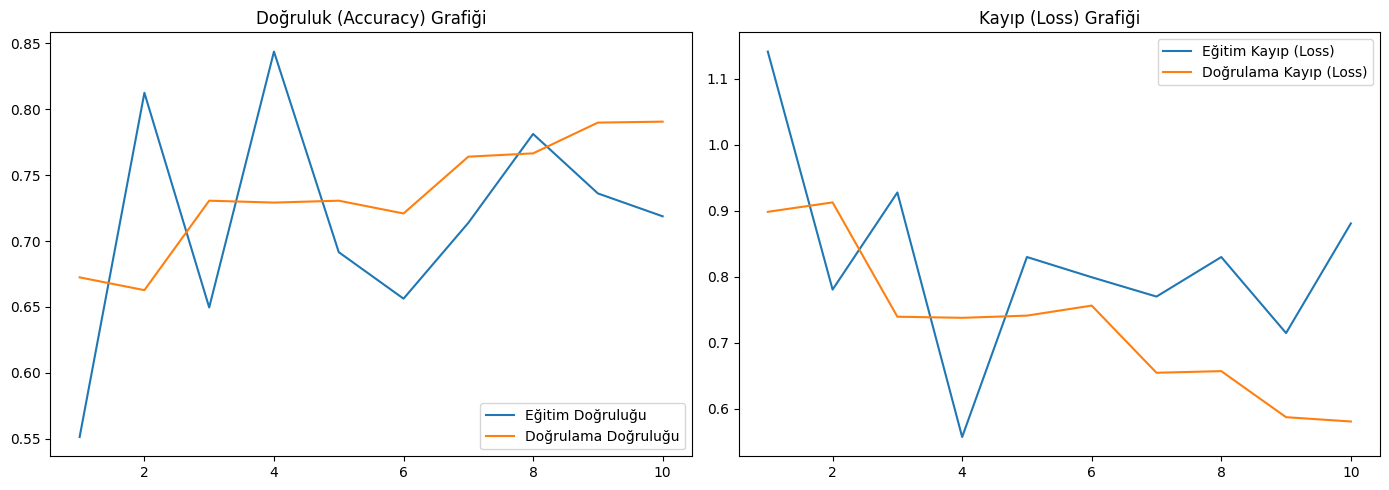

In [5]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Eğitim ve doğrulama loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Grafik çiz
plt.figure(figsize=(14, 5))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Doğruluk (Accuracy) Grafiği')

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kayıp (Loss)')
plt.plot(epochs_range, val_loss, label='Doğrulama Kayıp (Loss)')
plt.legend(loc='upper right')
plt.title('Kayıp (Loss) Grafiği')

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)




In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



In [9]:
# Tahminleri al
y_pred = []
y_true = []

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    preds = model.predict(x_batch, verbose=0)

    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y_batch, axis=1))

    if (i + 1) * val_generator.batch_size >= val_generator.samples:
        break


## 🔍 Confusion Matrix Analizi

Aşağıdaki Confusion Matrix, modelin doğrulama verisindeki sınıflandırma performansını detaylı şekilde göstermektedir.

- Satırlar: Gerçek sınıflar  
- Sütunlar: Modelin tahmin ettiği sınıflar

Köşegen üzerindeki sayılar doğru tahminleri, diğer hücreler ise yanlış tahminleri göstermektedir.  
Matrix'e bakıldığında:
- `forest`, `street`, `sea` gibi sınıflarda yüksek başarı elde edilmiştir.
- `mountain` ve `glacier` sınıfları arasında zaman zaman karışıklık yaşandığı görülmektedir.  
- Geliştirilmiş veri artırımı ve düşük öğrenme oranı ile karışıklık azalmıştır.

Bu analiz, modelin hangi sınıflarda güçlü olduğunu ve hangi sınıflarda gelişmeye açık olduğunu anlamamıza yardımcı olmuştur.


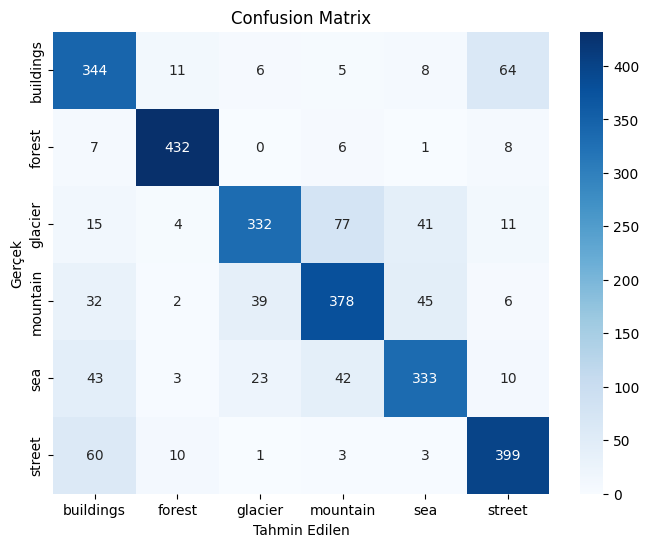

In [10]:
cm = confusion_matrix(y_true, y_pred)
class_names = list(val_generator.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()


In [13]:
# Sınıflandırma raporunu alalım
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

   buildings       0.69      0.79      0.73       438
      forest       0.94      0.95      0.94       454
     glacier       0.83      0.69      0.75       480
    mountain       0.74      0.75      0.75       502
         sea       0.77      0.73      0.75       454
      street       0.80      0.84      0.82       476

    accuracy                           0.79      2804
   macro avg       0.79      0.79      0.79      2804
weighted avg       0.79      0.79      0.79      2804



In [12]:
model.save("intel_model.h5")
